In [ ]:
!pip install line_profiler

     |████████████████████████████████| 66 kB 4.4 MB/s 


In [ ]:
#@title
!pip install gpflow
!pip install sortedcontainers 
!git clone https://github.com/j-wilson/GPflowSampling.git

     |████████████████████████████████| 287 kB 4.1 MB/s 
     |████████████████████████████████| 462 kB 39.6 MB/s 


Cloning into 'GPflowSampling'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 185 (delta 69), reused 162 (delta 55), pack-reused 0
Receiving objects: 100% (185/185), 3.83 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from sys import path as p
from matplotlib.collections import LineCollection as LC

p.insert(0, '/content/GPflowSampling')

from gpflow.config import default_float
from sortedcontainers import SortedSet, SortedList
from gpflow_sampling.sampling import priors, updates, decoupled
from gpflow_sampling.models import PathwiseGPR

In [ ]:
gpflow.config.set_default_float(np.float64)
np.random.seed(7)
tf.random.set_seed(7)

In [ ]:
from line_profiler import LineProfiler

# Кратчайший путь в графе

Истинная cost_function

In [ ]:
def Rosenbrock(x, a = 1, b = 100):
    return 0.01*((a - x[0])**2 + b*(x[1] - x[0]**2)**2) 

In [ ]:
def inv_soft(x):
    return np.log(np.exp(x) - 1)

def softplus(x):
    return np.log(np.exp(x) + 1)

def true_func(x):
    return inv_soft(Rosenbrock(x))

In [ ]:
def cost_of_path(path, func):
    value = 0
    for e in path:
        value += func(e)
    return value

Создаём grid размера (num_grid, num_grid)

In [ ]:
class Vertex:
    def __init__(self, ind: int, position: np.array, neighbors = None):
        # У вершины есть уникальный номер, её координаты на плоскоти и список соседей, с которыми она соединена ребром
        self.ind = ind 
        self.position = position
        self.neighbors = [] if neighbors is None else neighbors

    def __repr__(self):
        return f"({self.ind}, {[n.ind for n in self.neighbors]})"

    def __lt__(self, other):
        return self.position[0] < other.position[0]

In [ ]:
def make_ver(is_edge: np.array, pos: np.array):
    ver = [Vertex(i, p) for i, p in enumerate(pos)]
    for i in range(pos.shape[0]):
        for j in range(i + 1, pos.shape[0]):
            if is_edge[i][j]:
                ver[i].neighbors.append(ver[j])
                ver[j].neighbors.append(ver[i])
    return ver

In [ ]:
def make_edge(ver):
    edges = []
    for v in ver:
        for n in v.neighbors:
            edges.append(((v.ind, v.position), (n.ind, n.position)))
    return edges

In [ ]:
def make_grid(num_grid, x_lim = (-2, 2), y_lim = (-1, 4)):
    x, y = np.meshgrid(
        np.linspace(*x_lim, num_grid), np.linspace(*y_lim, num_grid)
    )
    positions = np.stack([x.flatten(), y.flatten()], axis = -1)
    is_there_edge = [[False for _ in range(len(positions))] for _ in range(len(positions))]
    # Соединяем вершины по направленияем N, E, S, W, NW, NE, SW, SE
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            if (j - i == 1 and j % num_grid != 0) or (j == i + num_grid):
                is_there_edge[i][j] = True
            elif (j == i + num_grid + 1 and i % num_grid != num_grid - 1) or (j == i + num_grid - 1 and i % num_grid != 0):
                is_there_edge[i][j] = True
    is_there_edge = np.array(is_there_edge)
    vertices = make_ver(is_there_edge, positions)
    edges = make_edge(vertices)

    return positions, vertices, edges

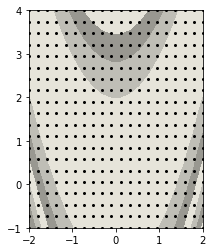

In [ ]:
pos, ver, edges = make_grid(20)
x = np.linspace(-2, 2, 20)
y = np.linspace(-1, 4, 20)
z = [[0 for _ in range(20)] for _ in range(20)]
for i in range(20):
    for j in range(20):
        z[i][j] = Rosenbrock(pos[i*20 + j])
h = plt.contourf(x, y, z, colors=['#E6E4DA', '#BFBEB6', '#999891'])
plt.plot(pos[:, 0], pos[:, 1], 'bo', color = 'black', markersize=2)
plt.axis('scaled')
plt.show()

Дейкстра (реализация с set'ом)

In [ ]:
class Dijkstra:
    def __init__(self, ver):
        self.ver = ver

    def value(self, v, neigh, is_func = True):
        if is_func:
          return self.cost_func(np.sum([v.position, neigh.position], axis = 0)/2)
        else:
            ind_1, ind_2 = v.ind, neigh.ind
            return self.cost_func[(ind_1, ind_2)] if ind_1 < ind_2 else self.cost_func[(ind_2, ind_1)] 

    def run_alg(self, start, end, cost_func, is_func = True):
        self.cost_func = cost_func
        self.start = self.ver[start]
        self.end = self.ver[end]
        n = len(self.ver)
        dist = [float("inf") for _ in range(n)]
        prev = [None for _ in range(n)]
        visited = [False for _ in range(n)]
        s = SortedList()
        dist[start] = 0
        s.add((dist[start], self.start))
        while len(s) != 0:
            d, v = s.pop(0)
            visited[v.ind] = True
            for neigh in v.neighbors:
                if visited[neigh.ind] == False:
                    val = self.value(v, neigh, is_func)
                    if dist[neigh.ind] > d + val:
                        s.discard((dist[neigh.ind], neigh))
                        dist[neigh.ind] = d + val
                        prev[neigh.ind] = v.ind
                        s.add((dist[neigh.ind], neigh))
        if not is_func:
            path = []
            val = []
            d = {}
            ver_in_path = end
            while ver_in_path != start:
                v_1, v_2 = self.ver[ver_in_path], self.ver[prev[ver_in_path]]
                # Снизу мы ограничиваем ситуации с перекрещивающимися рёбрами по диагонали (придумать адекатный вариант)
                if d.get(v_1.ind + v_2.ind) is None:
                    d[v_1.ind + v_2.ind] = 1
                    value = np.sum([v_1.position, v_2.position], axis = 0)/2
                    path.append(value)
                    if v_1.ind < v_2.ind:
                        val.append(self.cost_func[(v_1.ind, v_2.ind)])
                    else:
                        val.append(self.cost_func[(v_2.ind, v_1.ind)])
                ver_in_path = prev[ver_in_path]
            return dist[end], path, val
        else:
            path = []
            ver_in_path = end
            while ver_in_path != start:
                v_1, v_2 = self.ver[ver_in_path], self.ver[prev[ver_in_path]]
                value = np.sum([v_1.position, v_2.position], axis = 0)/2
                path.append(value)
                ver_in_path = prev[ver_in_path]
            return dist[end], path


In [ ]:
alg = Dijkstra(ver)

Прогнали алгоритм на истинной функции

In [ ]:
new_dist, new_path = alg.run_alg(380, 399, Rosenbrock)

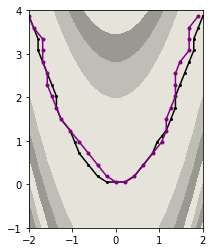

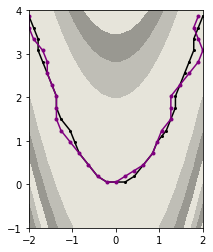

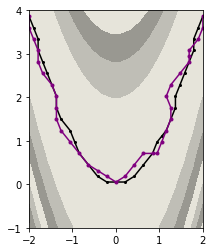

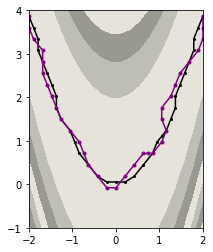

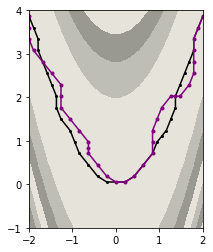

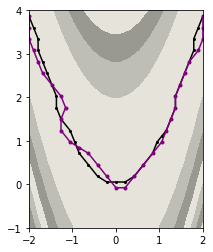

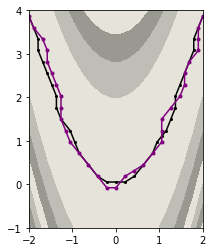

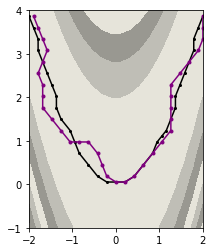

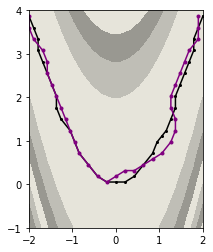

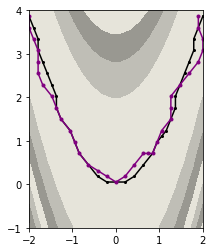

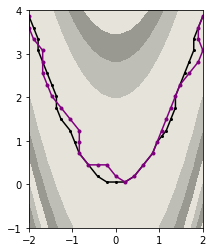

In [ ]:
path_x = [a[0] for a in new_path]
path_y = [a[1] for a in new_path]

x = np.linspace(-2, 2, 20)
y = np.linspace(-1, 4, 20)
z = [[0 for _ in range(20)] for _ in range(20)]
for i in range(20):
    for j in range(20):
        z[i][j] = Rosenbrock(pos[i*20 + j])
for i in range(11):
    h = plt.contourf(x, y, z, colors=['#E6E4DA', '#BFBEB6', '#999891'])
    plt.plot(path_x, path_y, '-o', color = 'black', markersize=2)
    plt.plot([e[0] for e in sampled_paths[i]], [e[1] for e in sampled_paths[i]], '-o', color = 'purple', markersize = 3)
    plt.axis('scaled')
    plt.show()

# Готовим всё для infoBAX'а

Готовим данные

In [ ]:
# Кол-во запросов к b-b функции
budget = 120
# Кол-во изначальных данных
init = 1
# Кол-во сэмплов для Монте-Карло и доля подвыборки пути
num_samples = 30
# Наша сетка: положение каждой вершины; вершины (каждая содержит свой индекс и положение); 
# рёбра (в виде ((v1.ind, v1.position), (v2.ind, v2.position)), содержит как (v1, v2), так и (v2, v1))
pos, ver, edges = make_grid(20)

# переопределяем рёбра (считаем, что ребро - положение между вершинами, которые он соединяет)
new_edges = []
for e in edges:
    if e[0][0] < e[1][0]:
        new_edges.append(((e[0][0], e[1][0]), np.sum([e[0][1], e[1][1]], axis = 0)/2))
edge_loc = np.array([e[1] for e in new_edges])

# псевдослучайно выбираем начальные init рёбер
ind_of_first_edges = np.random.choice(range(len(edge_loc)), init)
first_edges = [edge_loc[i] for i in ind_of_first_edges]

# Уже опрошенные места
already_known = set(ind_of_first_edges)

# параметры для GP
gp_params = {
    "var": 3,
    "l": 0.3,
    "noise": 0.01
}

kernels = {
    "SE": gpflow.kernels.SquaredExponential(variance=gp_params["var"], lengthscales=gp_params["l"]),
    "Matern32": gpflow.kernels.Matern32(variance=gp_params["var"], lengthscales=gp_params["l"]),
    "Matern52": gpflow.kernels.Matern52(variance=gp_params["var"], lengthscales=gp_params["l"])
}

# Начальный датасет
data = {
    "tf": (tf.constant([e for e in first_edges]), tf.constant([[true_func(e)] for e in first_edges])), 
}

# Модели с разными ядрами
model_1 = PathwiseGPR(data = data["tf"], kernel = kernels["SE"], noise_variance=gp_params["noise"])
model_2 = PathwiseGPR(data = data["tf"], kernel = kernels["Matern32"], noise_variance=gp_params["noise"])
model_3 = PathwiseGPR(data = data["tf"], kernel = kernels["Matern52"], noise_variance=gp_params["noise"])

# Подготовленный Дейкстра
alg = Dijkstra(ver)

Посчитаем первое слагаемое (энтропию) для EIG

In [ ]:
def entropy(model, X, compute_cov = True):
    num_ = X.shape[0]

    # Определитель матрицы ковариации 
    if compute_cov is True:
        # если есть модель
        det = model.predict_f(X)[1].numpy().reshape(num_) + gp_params["noise"]
    else:
        # если model = cov_X
        det = [model[i][i] + gp_params["noise"] for i in range(num_)]

    for i in range(num_):
        assert det[i] > 0
    H = 1/2 + 1/2*np.log(2*np.pi) + [np.log(det[i])/2 for i in range(num_)]
    return H

Начнём считать второе слагаемое: первое - это сэплирование

In [ ]:
# Для каждого сэмпла содержит кратчайший путь и значение его на подвыборке рёбер 
def sample(model, num_samples):
    paths = model.generate_paths(num_samples=num_samples, num_bases=1024)
    model.set_paths(paths)
    samples = model.predict_f_samples(tf.constant(edge_loc)).numpy().reshape((num_samples, -1))
    sub_pathes = dict([(i, _) for i in range(num_samples)])
    values = dict([(i, _) for i in range(num_samples)])

    for i in range(num_samples):
        # Считаем сэмплированую из predictive distribution функцию на всех рёбрах (рёбра для удобства индексируем, чтобы можно было обращаться)
        func = dict([(new_edges[j][0], softplus(samples[i][j])) for j in range(len(new_edges))])
        dist_, path_, val_ = alg.run_alg(380, 399, func, False)
        sub_pathes[i] = np.array(path_)
        values[i] = np.array(val_)

    return sub_pathes, values

Теперь считаем энтропию p(y_x|D_t,v_A)

In [ ]:
def entropy_of_post_pred_distr(X_new, ker, data, subseq):
    data = (data[0].numpy(), data[1].numpy())
    arr = np.concatenate((data[0], subseq))

    k_T = ker(X_new, arr).numpy()
    k_ = k_T.T

    I = np.zeros((len(arr), len(arr)))
    for i in range(len(data[0])):
        I[i][i] = gp_params["noise"]

    K = ker(arr, arr).numpy()
    K_inv = np.linalg.inv(K + I)

    cov = ker(X_new, X_new).numpy() - k_T@K_inv@k_ + (gp_params["noise"])**2*np.eye(X_new.shape[0])

    return entropy(cov, X_new, compute_cov = False)

Считаем EIG целиком

In [ ]:
def EIG(x, data, model, num_sam):
    first = entropy(model, X = x)
    sub_s, values = sample(model, num_sam)
    second = np.sum([entropy_of_post_pred_distr(x, model.kernel, data, sub_s[i]) for i in range(num_sam)], axis = 0)/num_sam
    return first + second

А вот и InfoBAX

In [ ]:
for t in range(budget): 
    # print(t + 1, 'epoch')
    sub_ed_first_edition = np.random.choice(range(len(edge_loc)), 100)
    sub_ed = []
    for i in sub_ed_first_edition:
        if i not in already_known:
            sub_ed.append(i)
    X = np.array([edge_loc[i] for i in sub_ed])
    # print('calculating EIG...')
    ind = np.argmax(EIG(X, data["tf"], model_3, num_samples)) 

    new_place_for_request = edge_loc[sub_ed[ind]]
    new_val = true_func(new_place_for_request)
    already_known.add(sub_ed[ind])
    # print('updating dataset')
    data["tf"] = (tf.concat((data["tf"][0], [new_place_for_request]), 0), tf.concat((data["tf"][1], [[new_val]]), 0))
    model_3 = PathwiseGPR(data = data["tf"], kernel = kernels['Matern52'], noise_variance=gp_params["noise"])

In [ ]:
sampled_paths, val = sample(model_3, 11)

# Анимация

In [ ]:
grid_size = 20
x1_lims = (-2, 2)
x2_lims = (-1, 4)
positions, vertices, edges = make_grid(grid_size, x1_lims, x2_lims)
edges_ = np.array([(e[0][1], e[1][1]) for e in edges])
start, goal = vertices[-grid_size], vertices[-1]

In [ ]:
def edges_of_path(path):
    edges = []
    for i in range(len(path) - 1):
        edges.append((path[i], path[i + 1]))
    return np.array(edges)

def positions_of_path(path):
    positions = [v[0][1] for v in path]
    positions.append(path[-1][1][1])
    return np.stack(positions)

In [ ]:
def plot_contourf(fig, ax, x1_lims, x2_lims):
    x, y = np.meshgrid(np.linspace(*x1_lims), np.linspace(*x2_lims))
    cs = ax.contourf(x, y, Rosenbrock((x, y)), colors = ['#F5F1F8', '#F1E1FC', '#F0C5EE', '#E4BBE2', '#C9A5C8', '#A386A2', '#786277'])
    cbar = fig.colorbar(cs, ax=ax)

def plot_graph(ax, edges, start, goal):
    # plot edges
    color = (0.75, 0.75, 0.75, 0.1)
    lc = LC(edges, colors=[color] * len(edges), linewidths=1.0)
    ax.add_collection(lc)

    # plot vertices
    ax.scatter(*positions.T, color=(0, 0, 0, 1), marker='.', facecolors='none', s=20)

    # plot start and goal vertices
    ax.scatter(*start.position, color='#FF530A', marker='s', label="Start", s=150)
    ax.scatter(*goal.position, color='#21FF65', marker='s', label="Goal", s=150)

    ax.grid(False)
    return

def plot_path(
    ax,
    path,
    path_color=(0, 0, 0, 1.),
    linewidths=2,
    linestyle="dotted",
    plot_vertices=False,
    label=None,
):
    # plot path taken
    path_lines = edges_of_path(path)
    path_lc = LC(
        path_lines,
        colors=[path_color] * len(path_lines),
        linewidths=linewidths,
        linestyle=linestyle,
        label=label,
    )
    ax.add_collection(path_lc)

    # plot visited vertices
    if plot_vertices:
        ax.scatter(*positions_of_path(path).T, color=(0, 0, 0, 1))
    return

Acq optimizer x_next = [ 0.94736842 -0.86842105]
Finished iter i = 1
Acq optimizer x_next = [-1.89473684 -0.86842105]
Finished iter i = 2
Acq optimizer x_next = [1.89473684 0.18421053]
Finished iter i = 3
Acq optimizer x_next = [-0.31578947 -0.60526316]
Finished iter i = 4
Acq optimizer x_next = [-1.26315789  0.57894737]
Finished iter i = 5
Acq optimizer x_next = [-1.89473684  1.76315789]
Finished iter i = 6
Acq optimizer x_next = [-1.11022302e-16  4.47368421e-01]
Finished iter i = 7
Acq optimizer x_next = [0.84210526 1.23684211]
Finished iter i = 8
Acq optimizer x_next = [2.         1.23684211]
Finished iter i = 9
Acq optimizer x_next = [ 1.89473684 -0.86842105]
Finished iter i = 10
Acq optimizer x_next = [-1.26315789 -0.34210526]
Finished iter i = 11
Acq optimizer x_next = [-1.89473684  2.55263158]
Finished iter i = 12
Acq optimizer x_next = [0.84210526 0.18421053]
Finished iter i = 13
Acq optimizer x_next = [-1.89473684  0.05263158]
Finished iter i = 14
Acq optimizer x_next = [-0.21

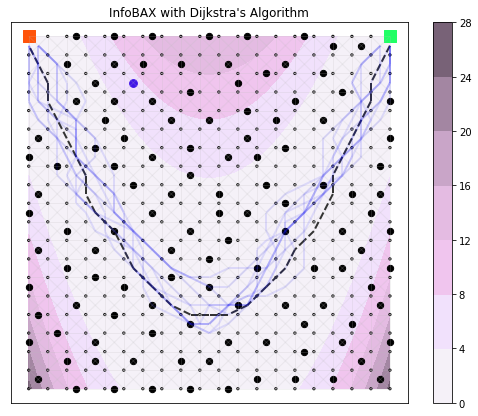

In [ ]:
for t in range(budget):
    plt.close()
    # Set model
    model_3 = PathwiseGPR(data = data["tf"], kernel = kernels["Matern52"], noise_variance=gp_params["noise"])

    # Set and optimize acquisition function
    sub_ed_first_edition = np.random.choice(range(len(edge_loc)), 100)
    sub_ed = []
    for i in sub_ed_first_edition:
        if i not in already_known:
            sub_ed.append(i)
    X = np.array([edge_loc[i] for i in sub_ed])
    ind = np.argmax(EIG(X, data['tf'], model_3, num_samples))
    new_place_for_request = edge_loc[sub_ed[ind]]
    sampled_paths, val = sample(model_3, 11)
    sampled_paths = [sampled_paths[j] for j in range(11)]

    # Print
    print(f'Acq optimizer x_next = {new_place_for_request}')
    print(f'Finished iter i = {t + 1}')

    fig, ax = plt.subplots(figsize=(8.9, 7)) # For square image, with colorbar

    plot_contourf(fig, ax, x1_lims, x2_lims)

    plot_graph(ax, edges_, start, goal)

    plot_path(
        ax,
        new_path,
        path_color=(0.2, 0.2, 0.2, 1),
        linewidths=2,
        linestyle='--',
        label='True shortest path',
    )

    data_ = (data['tf'][0].numpy(), data['tf'][1].numpy())

    for x in data_[0][:-1]:
            ax.scatter(x[0], x[1], color=(0, 0, 0, 1), s=40)

    ax.scatter(
        data_[0][-1][0],
        data_[0][-1][1],
        color='#3F15E8',
        s=60,
        label='Next query',
    )

    ax.set(ylim=[-1.2, 4.2], xlim=[-2.2, 2.2]) # TODO: replace hard coded values

    weight = 0.1 # NOTE can also do: 1 / acqfn.params.n_path
    for path in sampled_paths:
        plot_path(ax, path, path_color=(0, 0, 1, weight), linewidths=2, linestyle="-")

    # Plot title
    ax.set_title("InfoBAX with Dijkstra's Algorithm")

    # Turn off ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Save plot
    fig.savefig(f'/content/drive/My Drive/BAX/image{t + 1}.png')

    # Query function, update data
    new_val = true_func(new_place_for_request)
    already_known.add(sub_ed[ind])
    data["tf"] = (tf.concat((data["tf"][0], [new_place_for_request]), 0), tf.concat((data["tf"][1], [[new_val]]), 0))